# Array expression profiling

**Summary**

NOTCH proteins regulate signaling pathways involved in cellular differentiation, proliferation and death. 
Overactive Notch signaling as been observed in numerous cancers and has been extensively studied in the context of T-cell acute lymphoblastic leukemia (T-ALL) where more than 50% of pateints harbour mutant NOTCH1.
Small molecule modulators of these proteins would be important for understanding the role of NOTCH proteins in malignant and normal biological processes.

We were interested to measure the global changes in gene expression upon treatment of the human T-ALL cell lines HPB-ALL and KOPT-K1 with either vehicle alone (DMSO) or SAHM1, an alpha-helical hydrocarbon stapled peptide derived from the MAML1 co-activator protein.
 	
**Overall design**
Triplicate cultures of KOPT-K1 or HPB-ALL cells were treated with either DMSO alone or SAHM1 (20 uM) for 24 hours. Total RNA was extracted and hybridized to Affymetrix human U133 plus 2.0 microarrays (three arrays per treatment per cell line for a total of 12 arrays).

## Pipeline

In [5]:
import rpy2.rinterface
%reload_ext rpy2.ipython

In [9]:
%%R
##1. Load libraries
library("affy")
library("limma")
library("genefilter")
library(hgu133plus2.db)
wd = getwd()
wd

[1] "/Users/nandoide/misc_work/Desktop/uni/TRREP"


In [10]:
%%R
#Normalization and diferential expression for Affymetrix arrays
#2. Import .CEL files
setwd("GSE18198_data")
files_HPB <- list.files(pattern = "HPB*")
names_HPB <- gsub(".CEL.gz", "", files_HPB)
abatch_HPB <- ReadAffy(filenames = files_HPB,  compress = TRUE, sampleNames = names_HPB)
setwd(wd)

In [12]:
%%R
#3. Normalize with RMA 
#generates object eset (class ExprSet), 
#expresso function provides intensities in log scale
#pmonly = perfect match only method
eset_HPB <- expresso(abatch_HPB,
                 bg.correct = TRUE, 
                 bgcorrect.method="rma",
                 normalize = TRUE, 
                 normalize.method="quantiles", 
                 pmcorrect.method="pmonly", 
                 summary.method="medianpolish",
                 verbose = TRUE
) 

/Users/nandoide/miniconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)


background correction: rma 
normalization: quantiles 
PM/MM correction : pmonly 
expression values: medianpolish 
background correcting...done.
normalizing...done.
54675 ids to be processed
|                    |
|####################|


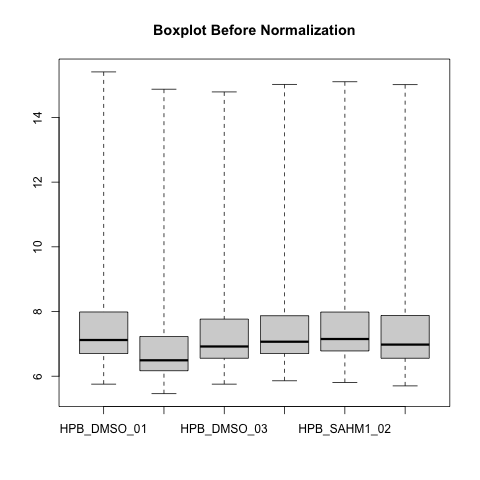

In [13]:
%%R
#4. Generate BOXPLOTS before and after normalization
#boxplot for raw data
boxplot(abatch_HPB,
        main="Boxplot Before Normalization",
        col = "lightgrey")

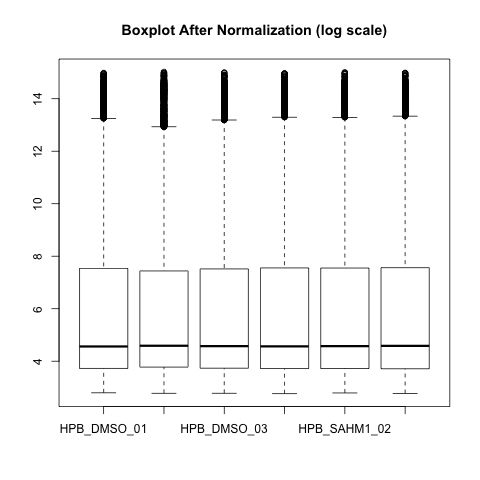

In [14]:
%%R
#boxplot for normalized data
df_eset_HPB <- as.data.frame(exprs(eset_HPB))
boxplot(data.frame(df_eset_HPB),
        main="Boxplot After Normalization (log scale)", col = "white")

In [15]:
%%R
#5.Data filtering using IQR.
esetIQR_HPB <- varFilter(eset_HPB, var.func=IQR, var.cutoff=0.5, filterByQuantile=TRUE)

#######Differential expression analysis.#######
#6. Design matrix.
design_HPB <- cbind(DMSO=c(1,1,1,0,0,0), SAHM1=c(0,0,0,1,1,1))

rownames(design_HPB) <- names_HPB

#7. Contrasts matrix.
cont.matrix_HPB <- makeContrasts(DMSO_SAHM1 = SAHM1 - DMSO, levels = design_HPB)

#8. Obtaining differentially expressed genes (DEGs)
#Linear model and eBayes 
fit <- lmFit(esetIQR_HPB, design_HPB)  ##getting DEGs from IQR 
fit2 <- contrasts.fit(fit, cont.matrix_HPB)
fit2 <- eBayes(fit2)

#Table with DEGs results
toptableIQR <- topTable(fit2, number=dim(exprs(esetIQR_HPB))[1], adjust.method="BH", sort.by="p")


In [30]:
%%R
#Gene Anotation
toptableIQR_HPB <- topTable(fit2, adjust.method = "fdr",
                         number=dim(exprs(esetIQR_HPB))[1], sort.by = "P" )
# Select probes with fdr<=0.05
toptableIQR_HPB_fdr05 <- subset(toptableIQR_HPB, toptableIQR_HPB$adj.P.Val<=0.05)

# Obtain gene names from probe names and chip symbol dataset
probenames_toptableIQR_HPB_fdr05 <- as.character(rownames(toptableIQR_HPB_fdr05 ))
genesymbols_toptableIQR_HPB_fdr05 <- as.character(mget(probenames_toptableIQR_HPB_fdr05,
                                  hgu133plus2SYMBOL))

# Annotated gene table
toptableIQR_anot <- cbind(Symbol = genesymbols_toptableIQR_HPB_fdr05, toptableIQR_HPB_fdr05)
#toptableIQR_anot

##9. Save results
save(toptableIQR_anot, file="IQR_HPB.RData")

In [31]:
%%R
options(repr.matrix.max.rows=50, repr.matrix.max.cols=6)
toptableIQR_anot[c(1,6)]

                              Symbol    adj.P.Val
201466_s_at                      JUN 2.108830e-06
201464_x_at                      JUN 7.688286e-06
229147_at                     RASSF6 7.688286e-06
230710_at                   MIR210HG 7.688286e-06
201465_s_at                      JUN 1.053822e-05
225342_at                        AK4 1.128982e-05
219270_at                      CHAC1 3.651273e-05
202672_s_at                     ATF3 3.651273e-05
207076_s_at                     ASS1 3.651273e-05
201842_s_at                   EFEMP1 6.004820e-05
235638_at                     RASSF6 7.997079e-05
200953_s_at                    CCND2 7.997079e-05
227336_at                       DTX1 8.636324e-05
222853_at                      FLRT3 1.138577e-04
227347_x_at                     HES4 1.228528e-04
202464_s_at                   PFKFB3 1.228528e-04
202022_at                      ALDOC 1.248092e-04
209921_at                    SLC7A11 1.248092e-04
240546_at                  LINC01120 1.552628e-04


# Outputs

In [28]:
%%bash
jupyter nbconvert --to=latex --template=~/report.tplx TRREP_final.ipynb
/Library/TeX/texbin/pdflatex -shell-escape TRREP_final
#jupyter nbconvert --to html_with_toclenvs TRREP_final.ipynb 1> /dev/null

This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=pdflatex)
 \write18 enabled.
entering extended mode
(./TRREP_final.tex
LaTeX2e <2018-04-01> patch level 2
Babel <3.18> and hyphenation patterns for 84 language(s) loaded.
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/size11.clo))
(/usr/local/texlive/2018/texmf-dist/tex/latex/placeins/placeins.sty)
(/usr/local/texlive/2018/texmf-dist/tex/latex/amsfonts/amssymb.sty
(/usr/local/texlive/2018/texmf-dist/tex/latex/amsfonts/amsfonts.sty))
(/usr/local/texlive/2018/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/local/texlive/2018/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/local/texlive/2018/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/local/texlive/2018/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/local/texlive/

[NbConvertApp] Converting notebook TRREP_final.ipynb to latex
/Users/nandoide/miniconda3/lib/python3.7/site-packages/nbconvert/utils/pandoc.py:52: RuntimeWarning: You are using an unsupported version of pandoc (2.2.3.2).
Your version must be at least (1.12.1) but less than (2.0.0).
Refer to http://pandoc.org/installing.html.
Continuing with doubts...
  check_pandoc_version()
/Users/nandoide/miniconda3/lib/python3.7/site-packages/nbconvert/utils/pandoc.py:52: RuntimeWarning: You are using an unsupported version of pandoc (2.2.3.2).
Your version must be at least (1.12.1) but less than (2.0.0).
Refer to http://pandoc.org/installing.html.
Continuing with doubts...
  check_pandoc_version()
/Users/nandoide/miniconda3/lib/python3.7/site-packages/nbconvert/utils/pandoc.py:52: RuntimeWarning: You are using an unsupported version of pandoc (2.2.3.2).
Your version must be at least (1.12.1) but less than (2.0.0).
Refer to http://pandoc.org/installing.html.
Continuing with doubts...
  check_pandoc_